In [1]:
import finnhub
from datetime import datetime, timedelta
import configparser
import pandas as pd

# Initialize the config parser
config = configparser.ConfigParser()
config.read(r'C:\Users\jbhan\Desktop\StockMarketNewsImpact\FinnhubAPI\config.ini')

# Retrieve the API key from the config file
api_key = config.get('finnhub', 'api_key')

# Initialize the Finnhub client
finnhub_client = finnhub.Client(api_key=api_key)

# Define the date range
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Convert dates to the required format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Fetch news articles
news = finnhub_client.company_news('TSLA', _from=start_date_str, to=end_date_str)
# len(news)

Building graph edges: 100%|██████████| 148785/148785 [00:26<00:00, 5618.10edge/s]
C:\Users\jbhan\AppData\Local\Temp\ipykernel_18640\882105219.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', num_clusters)
c:\Users\jbhan\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


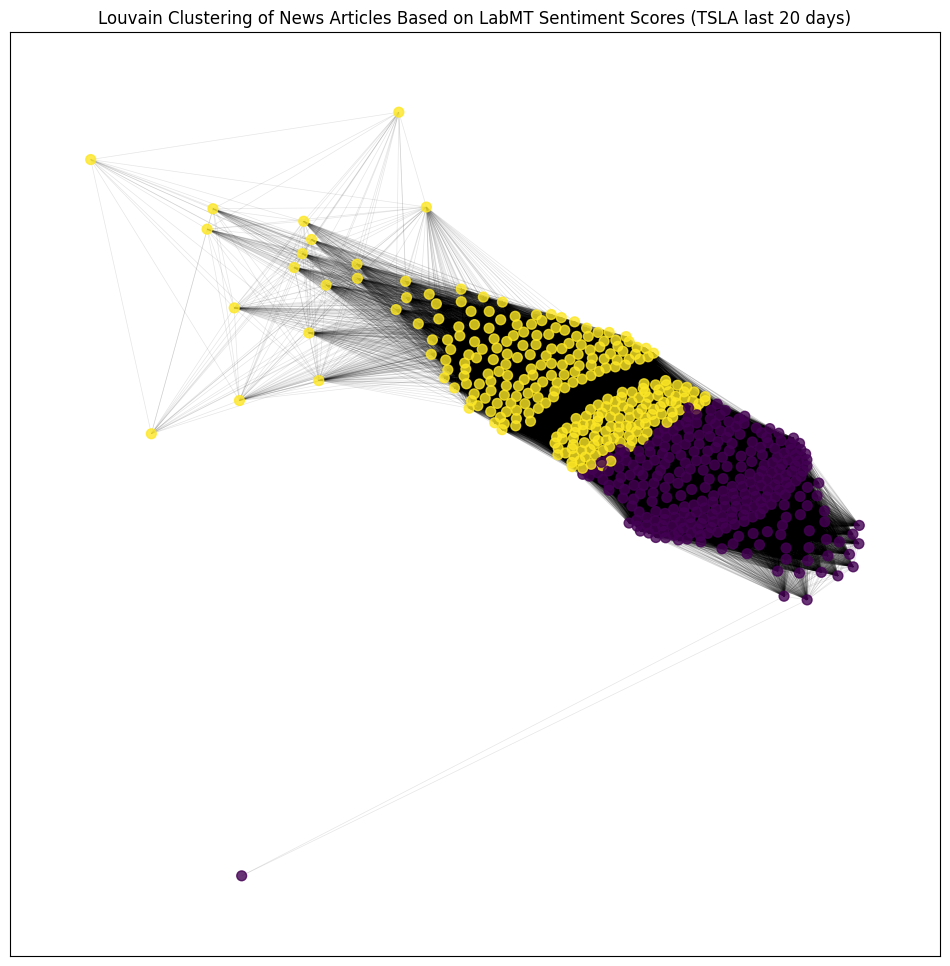


Cluster 1 - Number of Articles: 273
Average Sentiment: 5.30
  - Tech Flexes Earnings Power: A Closer Look (Sentiment Score: 5.30)
  - Mag 7 earnings underline the group's huge market influence (Sentiment Score: 5.38)
  - Is the EV Industry Facing Its Worst Growth Slowdown Amid Production Cuts? (Sentiment Score: 5.26)

Cluster 0 - Number of Articles: 273
Average Sentiment: 5.57
  - Tesla’s Sales Fall Behind BYD’s for the First Time. What It Means for Both Stocks. (Sentiment Score: 5.47)
  - Elon Musk's xAI Targets $40B Valuation as it Ramps Up Competition Against OpenAI (Sentiment Score: 5.49)
  - 5 Things Investors Should Not See In A 'Healthy' Economy (Sentiment Score: 5.45)


In [9]:
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import re
from tqdm import tqdm  # Import tqdm for progress bars

# Define date range for a year
end_date = datetime.now()
start_date = end_date - timedelta(days=20)

# Load the LabMT word list
file_path = r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\FinnhubAPI\LabMT_wordlist.txt"
df = pd.read_csv(file_path, sep='\s+', skiprows=2)
labmt_lexicon = dict(zip(df['word'], df['happiness_average']))

def calculate_sentiment(tokens):
    """Calculate sentiment score using LabMT lexicon."""
    sentiments = [labmt_lexicon.get(word, 5.0) for word in tokens]
    return np.mean(sentiments) if sentiments else 5.0  # Neutral score if no words found

def tokenize(text):
    """Simple tokenization function."""
    return re.findall(r'\b\w+\b', text.lower())

def fetch_news_sentiment(symbol, start, end):
    """Fetch news in chunks and calculate sentiment using LabMT."""
    news_data = []
    current_start_date = start
    with tqdm(total=(end - start).days // 7 + 1, desc=f"Fetching news for {symbol}", unit="chunk") as pbar:
        while current_start_date < end:
            chunk_end_date = min(current_start_date + timedelta(days=7), end)
            start_str = current_start_date.strftime('%Y-%m-%d')
            end_str = chunk_end_date.strftime('%Y-%m-%d')

            # Fetch news for the date chunk
            news_chunk = finnhub_client.company_news(symbol, _from=start_str, to=end_str)
            
            for article in news_chunk:
                tokens = tokenize(article['summary'])
                sentiment_score = calculate_sentiment(tokens)
                news_data.append({
                    'id': article['id'],
                    'datetime': datetime.fromtimestamp(article['datetime']),
                    'headline': article['headline'],
                    'sentiment_score': sentiment_score,
                    'url': article['url']
                })

            current_start_date = chunk_end_date + timedelta(days=1)
            pbar.update(1)  # Update the progress bar

    # Remove duplicates based on 'id'
    return pd.DataFrame(news_data).drop_duplicates(subset='id')

# Fetch news and sentiment data for the company (e.g., TSLA)
news_df = fetch_news_sentiment('TSLA', start_date, end_date)

# Build a graph from the news data
G = nx.Graph()
for i, article in news_df.iterrows():
    G.add_node(i, title=article['headline'], date=article['datetime'], url=article['url'], sentiment=article['sentiment_score'])

# Add edges between nodes based on similar sentiment scores
threshold = 0.25  # Adjust threshold to connect nodes with similar sentiment
with tqdm(total=len(news_df) * (len(news_df) - 1) // 2, desc="Building graph edges", unit="edge") as pbar:
    for i in range(len(news_df)):
        for j in range(i + 1, len(news_df)):
            if abs(news_df.iloc[i]['sentiment_score'] - news_df.iloc[j]['sentiment_score']) < threshold:
                G.add_edge(i, j, weight=1 - abs(news_df.iloc[i]['sentiment_score'] - news_df.iloc[j]['sentiment_score']))
            pbar.update(1)

# Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Color nodes based on their cluster
num_clusters = len(set(partition.values()))
color_map = plt.cm.get_cmap('viridis', num_clusters)
node_colors = [color_map(partition[node]) for node in G.nodes()]

# Draw the graph with a spring layout
pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
plt.title('Louvain Clustering of News Articles Based on LabMT Sentiment Scores (TSLA last 20 days)')
plt.show()

# Display cluster details
cluster_details = {}
for node, cluster_id in partition.items():
    if cluster_id not in cluster_details:
        cluster_details[cluster_id] = []
    cluster_details[cluster_id].append({
        'headline': G.nodes[node]['title'],
        'sentiment': G.nodes[node]['sentiment']
    })

# Print sample headlines and sentiments from each cluster
for cluster_id, articles in cluster_details.items():
    print(f"\nCluster {cluster_id} - Number of Articles: {len(articles)}")
    print(f"Average Sentiment: {np.mean([article['sentiment'] for article in articles]):.2f}")
    for article in articles[:3]:  # Display up to 3 articles per cluster
        print(f"  - {article['headline']} (Sentiment Score: {article['sentiment']:.2f})")


In [10]:
# Dictionary to store headlines, sources, and URLs for each cluster
cluster_details = {}

# Iterate through nodes and group by cluster
for node, cluster_id in partition.items():
    if cluster_id not in cluster_details:
        cluster_details[cluster_id] = []
    
    # Get article information from the graph nodes and news data
    article_info = {
        'headline': G.nodes[node].get('title', 'No Title'),
        'source': news_df.iloc[node].get('source', 'Unknown'),  # Use `news_df` to get source info
        'url': news_df.iloc[node]['url'],
        'sentiment': G.nodes[node]['sentiment']
    }
    
    # Append the article information to the cluster's list
    cluster_details[cluster_id].append(article_info)

# Display headlines, sources, URLs, and sentiment scores for each cluster
for cluster_id, articles in cluster_details.items():
    print(f"\nCluster {cluster_id} - Number of Articles: {len(articles)}")
    print(f"Average Sentiment: {np.mean([article['sentiment'] for article in articles]):.2f}")
    print("Sample Articles:")
    for article in articles[:5]:  # Display up to 5 articles per cluster as a sample
        print(f"  - {article['headline']} (Source: {article['source']})")
        print(f"    URL: {article['url']}")
        print(f"    Sentiment Score: {article['sentiment']:.2f}")



Cluster 1 - Number of Articles: 273
Average Sentiment: 5.30
Sample Articles:
  - Tech Flexes Earnings Power: A Closer Look (Source: Unknown)
    URL: https://finnhub.io/api/news?id=a2e0a3f5baf2e186ff215686bfb4bff6cc276cc8f205149efe7348df39eb39a6
    Sentiment Score: 5.30
  - Mag 7 earnings underline the group's huge market influence (Source: Unknown)
    URL: https://finnhub.io/api/news?id=ea76e3e38c82798208598957d1f9f37725dda55b53469597236bab184ea22402
    Sentiment Score: 5.38
  - Is the EV Industry Facing Its Worst Growth Slowdown Amid Production Cuts? (Source: Unknown)
    URL: https://finnhub.io/api/news?id=acda64cf1d8d481dcfe7d2a1d5e64a70f712893def8844cf00755deda8f25c25
    Sentiment Score: 5.26
  - Cathie Wood's Sky-High Vision: Dumps Shares Of Cybercab Touting Tesla For This eVTOL Play (Source: Unknown)
    URL: https://finnhub.io/api/news?id=97775b08bb28a73db652b62c0a211a625f02511319ecd3d548026eb791e8f1b8
    Sentiment Score: 5.37
  - Elon Musk says there’s a 10% to 20% chanc

C:\Users\jbhan\AppData\Local\Temp\ipykernel_18640\516997446.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_finbert = plt.cm.get_cmap('viridis', num_clusters_finbert)


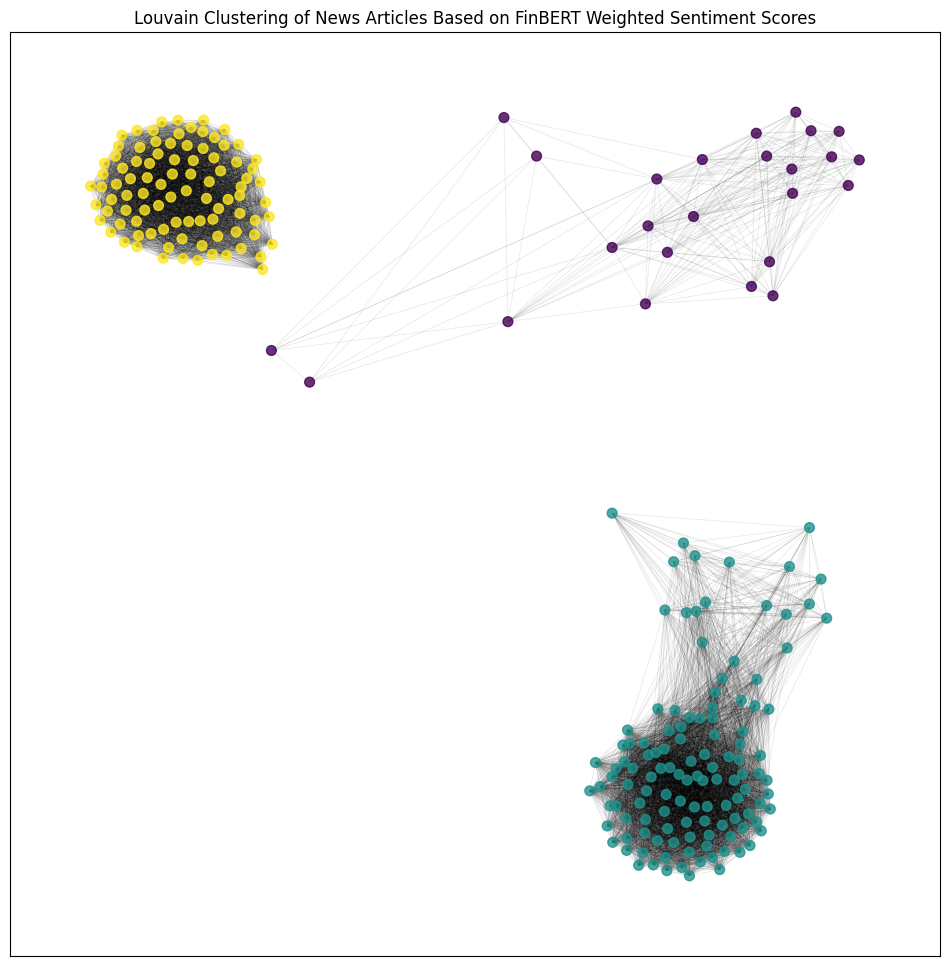

In [11]:
from transformers import pipeline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib.pyplot as plt

# Load the FinBERT model for sentiment analysis
finbert_sentiment = pipeline("sentiment-analysis", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert", truncation=True, max_length=128, device=0)

def analyze_sentiment(text):
    # Get the full output with confidence scores for each label
    results = finbert_sentiment(text)
    
    # Confidence scores for each sentiment
    positive_score = next((item['score'] for item in results if item['label'] == 'positive'), 0)
    negative_score = next((item['score'] for item in results if item['label'] == 'negative'), 0)
    neutral_score = next((item['score'] for item in results if item['label'] == 'neutral'), 0)
    
    # Calculate a weighted sentiment score:
    # Positive = +1.0, Neutral = 0.0, Negative = -1.0
    sentiment_score = positive_score * 1.0 + neutral_score * 0.0 + negative_score * -1.0
    
    return sentiment_score

# Function to adjust sentiment for short-seller context
def adjust_sentiment_for_short_sellers(text, original_score):
    short_seller_keywords = ["short-seller", "shorting", "shorts", "hammered", "loss", "hit", "crushed"]
    if any(keyword in text.lower() for keyword in short_seller_keywords):
        return abs(original_score) if original_score < 0 else original_score
    else:
        return original_score

# Calculate sentiment using FinBERT and adjust if necessary
for article in news:
    sentiment_score = analyze_sentiment(article['summary'])  # FinBERT score
    article['finbert_sentiment_score'] = adjust_sentiment_for_short_sellers(article['summary'], sentiment_score)

# Initialize a new graph for FinBERT-based sentiment analysis
G_finbert = nx.Graph()

# Add nodes with article details
for i, article in enumerate(news):
    G_finbert.add_node(i, title=article['headline'], date=article['datetime'], url=article['url'], sentiment=article['finbert_sentiment_score'])

# Add edges based on sentiment similarity
threshold = 0.25  # Adjust threshold as needed
for i in range(len(news)):
    for j in range(i + 1, len(news)):
        if abs(news[i]['finbert_sentiment_score'] - news[j]['finbert_sentiment_score']) < threshold:
            G_finbert.add_edge(i, j, weight=1 - abs(news[i]['finbert_sentiment_score'] - news[j]['finbert_sentiment_score']))

# Apply Louvain clustering on the new graph
partition_finbert = community_louvain.best_partition(G_finbert)

# Assign colors based on clusters
num_clusters_finbert = len(set(partition_finbert.values()))
color_map_finbert = plt.cm.get_cmap('viridis', num_clusters_finbert)
node_colors_finbert = [color_map_finbert(partition_finbert[node]) for node in G_finbert.nodes()]

# Draw the FinBERT-based graph
plt.figure(figsize=(12, 12))
pos_finbert = nx.spring_layout(G_finbert, k=0.5)
nx.draw_networkx_nodes(G_finbert, pos_finbert, node_size=50, node_color=node_colors_finbert, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G_finbert, pos_finbert, alpha=0.1, width=0.5)
plt.title('Louvain Clustering of News Articles Based on FinBERT Weighted Sentiment Scores')
plt.show()


In [13]:
# Create a dictionary to store headlines, sentiments, and URLs for each cluster in the FinBERT graph
cluster_details_finbert = {}
for node, cluster_id in partition_finbert.items():  # Use partition_finbert for FinBERT-based clustering
    if cluster_id not in cluster_details_finbert:
        cluster_details_finbert[cluster_id] = []
    
    # Append article details to the cluster
    cluster_details_finbert[cluster_id].append({
        'headline': G_finbert.nodes[node]['title'],  # Use G_finbert nodes for FinBERT graph
        'sentiment': G_finbert.nodes[node]['sentiment'],
        'url': G_finbert.nodes[node]['url']
    })

# Display sample headlines, sentiments, and URLs from each FinBERT cluster
for cluster_id, articles in cluster_details_finbert.items():
    print(f"\nCluster {cluster_id} - Number of Articles: {len(articles)}")
    print(f"Average Sentiment: {np.mean([article['sentiment'] for article in articles]):.2f}")
    for article in articles[:3]:  # Display up to 3 articles per cluster as a sample
        print(f"  - {article['headline']} (Sentiment Score: {article['sentiment']:.2f})")
        print(f"    URL: {article['url']}")



Cluster 0 - Number of Articles: 25
Average Sentiment: -0.86
  - We May Not Get Our Recession Until The AI Spending Bubble Implodes (Sentiment Score: -0.96)
    URL: https://finnhub.io/api/news?id=5690859897cddca78dd383c83ead28d1fa27d9517c4fd8b3c7edea58ed94074c
  - Sector Update: Consumer Stocks Mixed in Late Afternoon Trading (Sentiment Score: -0.96)
    URL: https://finnhub.io/api/news?id=65f6e57a636411cff176e3039df29ec6e052d49049a47b987dab3cdad644cb82
  - Volkswagen AG's Fledgling Scout Brand Faces Opposition From Powerful U.S. Dealer Lobby (Sentiment Score: -0.76)
    URL: https://finnhub.io/api/news?id=9d0592ceb1024c0bef78305450a3e4b88ec8543c80044c103fe7f063a834e9da

Cluster 1 - Number of Articles: 121
Average Sentiment: 0.83
  - Trump trade powers Dow 44,000, S&P 6,000 as stocks keep humming (Sentiment Score: 0.81)
    URL: https://finnhub.io/api/news?id=2213c088ea2f826e7c5e939cb0c106bf7f9b3d7de1adfb9655c763259367678b
  - Tesla Fans Go All In Driving $300 Billion Rally on Trump W

In [17]:
# List of company symbols
companies = ['AAPL', 'TSLA', 'GOOGL', 'MSFT', 'META', 'AMZN', 'NVDA']

# Define the time frame (e.g., past 365 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=5)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')
news = finnhub_client.company_news("TSLA", _from=start_str, to=end_str)

news[0]

{'category': 'company',
 'datetime': 1731397753,
 'headline': "Musk's Starlink working on Indian security clearance for satellite broadband",
 'id': 131303140,
 'image': '',
 'related': 'TSLA',
 'source': 'Finnhub',
 'summary': "Elon Musk's Starlink is seeking security clearance for a licence to offer satellite broadband services in India and will get a permit if it satisfies all conditions, the telecoms minister said on...",
 'url': 'https://finnhub.io/api/news?id=c119106b886318c0c94453f598112181c7733f81e5ebd0c4925d54540bb2ada4'}

In [ ]:
import finnhub
import pandas as pd
from datetime import datetime, timedelta
from transformers import pipeline
from tqdm import tqdm

# Initialize the FinBERT sentiment analysis pipeline
finbert_sentiment = pipeline("sentiment-analysis", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert", truncation=True, max_length=128, device=0)


# List of company symbols
companies = ['AAPL', 'TSLA', 'GOOGL', 'MSFT', 'META', 'AMZN', 'NVDA']

# Define the time frame (e.g., past 365 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

def analyze_sentiment_with_finbert(text):
    """Analyze sentiment using FinBERT and return a numerical score."""
    result = finbert_sentiment(text)[0]
    if result['label'] == 'positive':
        return 1.0
    elif result['label'] == 'negative':
        return -1.0
    else:
        return 0.0

def fetch_news_sentiment(symbol, start, end):
    """Fetch news for a given company in smaller chunks and calculate sentiment using FinBERT."""
    news_data = []
    
    # Loop through the date range in smaller chunks (e.g., 2 days)
    current_start_date = start
    with tqdm(total=(end - start).days // 2, desc=f"Fetching {symbol}", leave=False) as pbar:
        while current_start_date < end:
            # Define the chunk end date
            chunk_end_date = min(current_start_date + timedelta(days=7), end)
            
            # Convert dates to ISO format
            start_str = current_start_date.strftime('%Y-%m-%d')
            end_str = chunk_end_date.strftime('%Y-%m-%d')
            
            # Fetch company news for the date chunk
            news_chunk = finnhub_client.company_news(symbol, _from=start_str, to=end_str)
            
            # Extract relevant information and analyze sentiment
            for article in news_chunk:
                # Check if datetime is in milliseconds or seconds
                timestamp = article['datetime']
                date = datetime.fromtimestamp(timestamp / 1000) if timestamp > 1e12 else datetime.fromtimestamp(timestamp)
                headline = article['headline']
                
                # Calculate sentiment score using FinBERT
                sentiment_score = analyze_sentiment_with_finbert(headline)
                
                news_data.append({'id': article['id'], 'date': date, 'headline': headline, 'sentiment': sentiment_score, 'url': article['url'], 'summary': article.get('summary', ''), 'source': article.get('source', '')})
            
            # Move the start date forward for the next chunk
            current_start_date = chunk_end_date + timedelta(days=1)
            
            # Update progress bar
            pbar.update(1)

    # Convert to DataFrame and remove duplicates based on 'id'
    news_df = pd.DataFrame(news_data).drop_duplicates(subset='id')
    return news_df

# Fetch news and sentiment data for all companies with an outer tqdm loop
all_news = pd.DataFrame()
for company in tqdm(companies, desc="Processing companies"):
    news_df = fetch_news_sentiment(company, start_date, end_date)
    news_df['company'] = company  # Add the company name to the DataFrame
    all_news = pd.concat([all_news, news_df], ignore_index=True)

# Display the collected news with sentiment scores
print(all_news.head())
print(f"Total unique articles fetched: {len(all_news)}")


Processing companies:   0%|          | 0/7 [01:00<?, ?it/s]


KeyboardInterrupt: 

In [22]:
all_news["source"].value_counts()

source
Yahoo           569
SeekingAlpha    142
MarketWatch      44
Finnhub          39
DowJones          8
Name: count, dtype: int64

In [19]:
# save the data to a CSV file
all_news.to_csv('news_sentiment_data.csv', index=False)

In [20]:
print(all_news["company"].value_counts())
all_news["sentiment"].value_counts()

company
NVDA     164
TSLA     151
AMZN     134
MSFT     111
AAPL      88
GOOGL     79
META      75
Name: count, dtype: int64


sentiment
 0.0    480
 1.0    206
-1.0    116
Name: count, dtype: int64

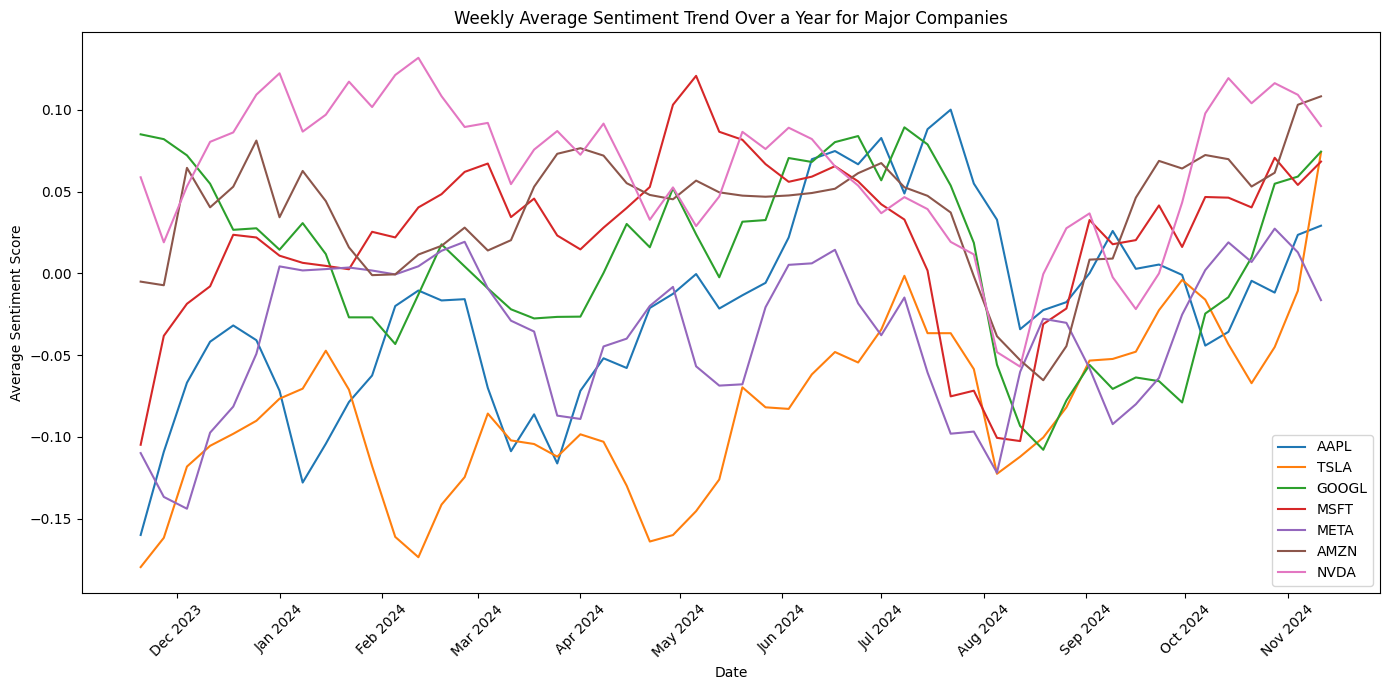

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Ensure 'date' is in datetime format and filter relevant dates
all_news['date'] = pd.to_datetime(all_news['date'])
all_news = all_news[(all_news['date'] >= start_date) & (all_news['date'] <= end_date)]

# Set 'date' as the index
all_news.set_index('date', inplace=True)

# Resample the data by week for each company and calculate the mean sentiment score
weekly_sentiment = all_news.groupby('company').resample('W-MON')['sentiment'].mean().reset_index()

# Plot the weekly average sentiment scores with a 4-week rolling average for smoothing
plt.figure(figsize=(14, 7))
for company in companies:
    company_data = weekly_sentiment[weekly_sentiment['company'] == company]
    plt.plot(company_data['date'], company_data['sentiment'].rolling(window=4, min_periods=1).mean(), label=company)

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.title("Weekly Average Sentiment Trend Over a Year for Major Companies")
plt.legend()

# Format x-axis for a year-long plot
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Show month and year
plt.xticks(rotation=45)  # Rotate date labels for readability

plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
all_news_path = r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\FinnhubAPI\news_sentiment_data.csv"
all_news = pd.read_csv(all_news_path)

In [15]:
# check nan values
print(all_news.isnull().sum())
# Drop rows with missing values
all_news.dropna(inplace=True)

id           0
headline     3
sentiment    0
company      0
dtype: int64


In [16]:
len(all_news)

109569

100%|██████████| 50/50 [19:19<00:00, 23.19s/it]


BarnesHut Approximation  took  111.09  seconds
Repulsion forces  took  1040.92  seconds
Gravitational forces  took  0.45  seconds
Attraction forces  took  4.70  seconds
AdjustSpeedAndApplyForces step  took  1.70  seconds


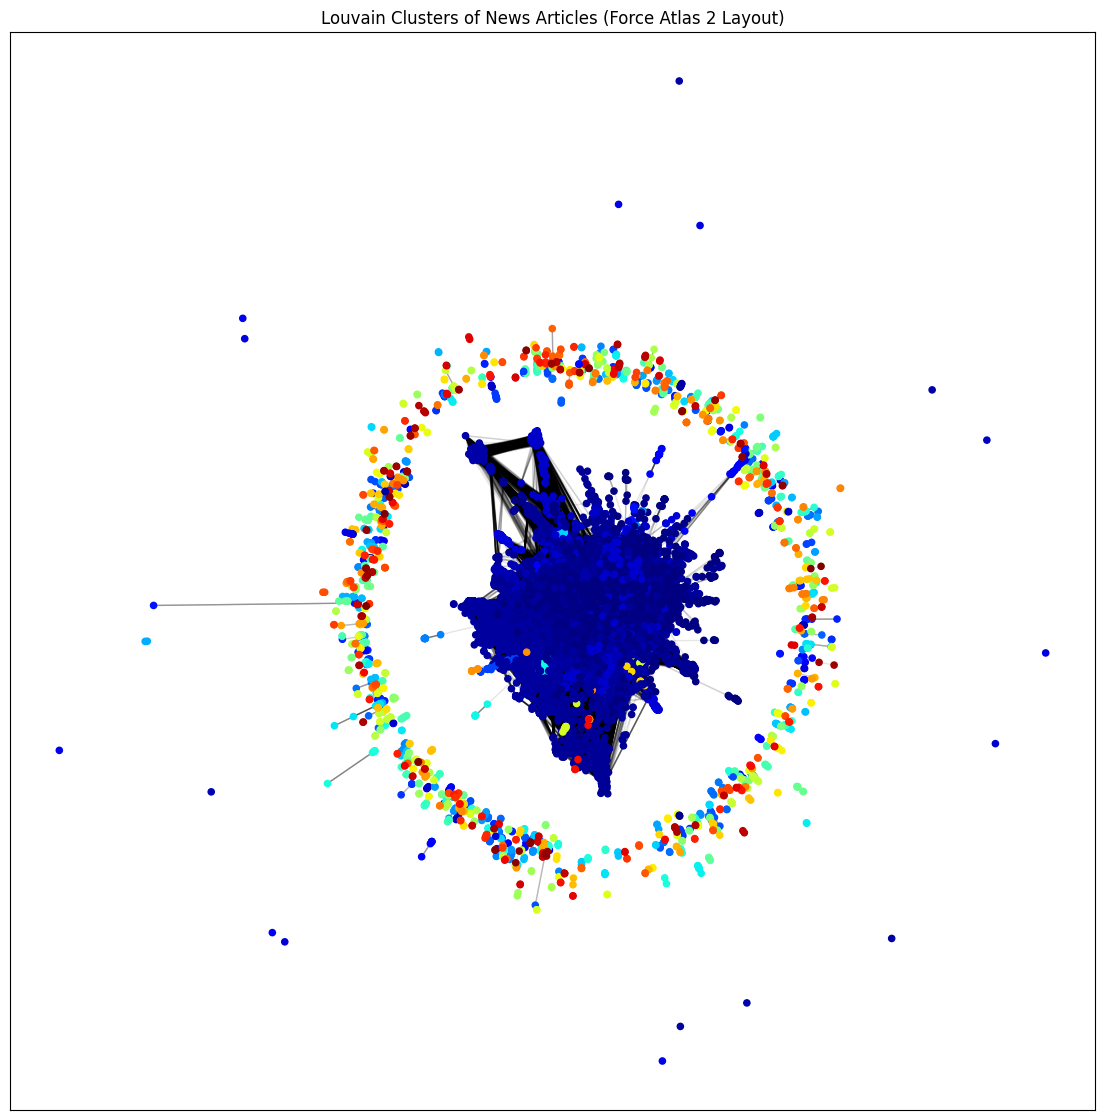

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
import community as community_louvain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np

# Step 1: Convert headlines to TF-IDF features for similarity computation (sparse)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(all_news['headline'])

# Step 2: Compute sparse cosine similarity matrix (only retain similarities > 0.3)
cosine_similarities = cosine_similarity(tfidf_matrix, dense_output=False)
cosine_similarities = cosine_similarities.multiply(cosine_similarities > 0.3)  # Apply threshold

# Step 3: Create the Graph with Articles as Nodes
G = nx.Graph()

# randomly sample 1000 articles for visualization
all_news = all_news.sample(1000, random_state=1)

# Add nodes for each article
for i, article in all_news.iterrows():
    G.add_node(i, company=article['company'], sentiment=article['sentiment'], headline=article['headline'])

# Step 4: Add edges based on sparse similarity matrix
rows, cols = cosine_similarities.nonzero()
for row, col in zip(rows, cols):
    if row < col:  # Avoid duplicate edges in an undirected graph
        G.add_edge(row, col, weight=cosine_similarities[row, col])

# Step 5: Apply Force Atlas 2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)

# Compute layout
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

# Step 6: Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Step 7: Visualize the graph with clusters
plt.figure(figsize=(14, 14))
colors = [partition[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(G, positions, alpha=0.1)

plt.title("Louvain Clusters of News Articles (Force Atlas 2 Layout)")
plt.show()


In [13]:
partition

{28670: 0,
 1274: 1,
 60170: 2,
 40914: 3,
 26121: 3,
 49244: 4,
 52963: 5,
 96823: 6,
 50826: 4,
 83499: 4,
 27805: 4,
 20367: 20,
 22014: 8,
 93003: 5,
 82377: 3,
 2483: 3,
 69470: 5,
 7914: 4,
 62576: 9,
 1540: 1,
 55193: 4,
 28470: 20,
 30718: 20,
 101891: 10,
 89707: 9,
 21174: 3,
 75618: 2,
 92994: 9,
 60211: 3,
 60116: 11,
 13348: 10,
 101407: 12,
 80735: 11,
 5090: 9,
 86451: 13,
 39025: 14,
 95365: 3,
 41734: 20,
 30865: 12,
 86594: 4,
 9018: 10,
 17946: 15,
 24508: 3,
 26384: 20,
 9959: 0,
 52766: 4,
 58569: 3,
 85396: 3,
 66049: 3,
 45782: 9,
 35243: 16,
 47238: 12,
 5647: 12,
 11544: 5,
 102470: 9,
 60745: 17,
 9794: 3,
 28368: 4,
 53477: 4,
 37454: 18,
 2813: 54,
 7537: 20,
 41437: 21,
 31352: 22,
 12434: 23,
 35231: 16,
 24369: 9,
 1554: 4,
 34398: 24,
 41927: 5,
 32063: 3,
 9407: 24,
 82263: 15,
 78301: 3,
 108857: 3,
 11371: 25,
 37580: 0,
 53352: 54,
 5953: 54,
 27924: 9,
 2936: 1,
 101802: 6,
 64620: 10,
 56147: 26,
 48775: 3,
 107889: 54,
 66662: 11,
 37219: 12,
 676